<a href="https://colab.research.google.com/github/ruorong/classifcation/blob/main/classfication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import os
import time
import random
import datetime
import sklearn

In [ ]:
tf.__version__

'2.6.0'

In [ ]:
!git clone https://github.com/ruorong/classifcation.git

Cloning into 'classifcation'...
remote: Enumerating objects: 2563, done.
remote: Counting objects: 100% (2563/2563), done.
remote: Compressing objects: 100% (2561/2561), done.
remote: Total 2563 (delta 17), reused 2537 (delta 1), pack-reused 0
Receiving objects: 100% (2563/2563), 92.79 MiB | 8.98 MiB/s, done.
Resolving deltas: 100% (17/17), done.


# 数据增强

In [ ]:
# for dirs in glob.glob("/content/classifcation/Garbagepicture/*"):
#   print(dirs)


/content/classifcation/Garbagepicture/paper
/content/classifcation/Garbagepicture/plastic
/content/classifcation/Garbagepicture/glass
/content/classifcation/Garbagepicture/cardboard
/content/classifcation/Garbagepicture/metal


In [ ]:
# for dirs in glob.glob("/content/classifcation/Garbagepicture/*"): 
#   # print(dirs)
#   paths = glob.glob(dirs + "/*")
#   # print(paths)
# print(paths)

['/content/classifcation/Garbagepicture/metal/metal90.jpg', '/content/classifcation/Garbagepicture/metal/metal409.jpg', '/content/classifcation/Garbagepicture/metal/metal220.jpg', '/content/classifcation/Garbagepicture/metal/metal111.jpg', '/content/classifcation/Garbagepicture/metal/metal362.jpg', '/content/classifcation/Garbagepicture/metal/metal18.jpg', '/content/classifcation/Garbagepicture/metal/metal25.jpg', '/content/classifcation/Garbagepicture/metal/metal75.jpg', '/content/classifcation/Garbagepicture/metal/metal202.jpg', '/content/classifcation/Garbagepicture/metal/metal373.jpg', '/content/classifcation/Garbagepicture/metal/metal294.jpg', '/content/classifcation/Garbagepicture/metal/metal351.jpg', '/content/classifcation/Garbagepicture/metal/metal115.jpg', '/content/classifcation/Garbagepicture/metal/metal149.jpg', '/content/classifcation/Garbagepicture/metal/metal280.jpg', '/content/classifcation/Garbagepicture/metal/metal274.jpg', '/content/classifcation/Garbagepicture/meta

In [ ]:
# print(time.time())

1635056641.81943


In [ ]:
# for dirs in glob.glob("/content/classifcation/Garbagepicture/*"): 
#   # print(dirs)
#   paths = glob.glob(dirs + "/*")
#   # print(paths)
#   for path in paths:
#     temp = os.path.dirname(path) + "/" + str(time.time()) + ".png"
#     # temp = os.path.dirname(path)  # 去掉文件名，返回目录  
#     print(temp)

In [ ]:
# # start = datetime.datetime.now()
# for dirs in glob.glob("/content/classifcation/Garbage classification/*"): # glob返回list。返回classfication下目录
#   paths = glob.glob(dirs + "/*") # 以列表返回
  
#   for path in paths[:2]:
#     img = tf.keras.preprocessing.image.load_img(path)
#     img = np.array(img) # 转化为 ndarray的形式
#     img = tf.image.adjust_brightness(img,0.3) # 调整 RGB 或灰度图像的亮度
#     temp = os.path.dirname(path) + "/" + str(time.time()) + ".png"
#     # tf.keras.preprocessing.image.save_img(temp,img)

In [ ]:
# 数据增强，加强亮度
start = datetime.datetime.now()
for dirs in glob.glob("/content/classifcation/Garbagepicture/*"): # glob返回list。返回classfication下目录
  paths = glob.glob(dirs + "/*") # 以列表返回
  
  for path in paths:
    img = tf.keras.preprocessing.image.load_img(path)
    img = np.array(img) # 转化为 ndarray的形式
    img = tf.image.adjust_brightness(img,0.3) # 调整 RGB 或灰度图像的亮度
    temp = os.path.dirname(path) + "/" + str(time.time()) + ".png"
    tf.keras.preprocessing.image.save_img(temp,img)
  for path in paths:
    img = tf.keras.preprocessing.image.load_img(path)
    img = np.array(img) # 转化为 ndarray的形式
    img = tf.image.flip_left_right(img) #水平翻转图像(从左到右)
    temp = os.path.dirname(path) + "/" + str(time.time()) + ".png"
    tf.keras.preprocessing.image.save_img(temp,img)
end = datetime.datetime.now()
print(end-start)

0:03:25.718557


In [ ]:
!pwd
# !mv /content/classifcation/ /content/yes
# !mv /content/old2/ /content/classifcation
# !rm /content/classifcation/ -rf
# !rm /content/image.csv


/content


In [ ]:
# # 数据增强，加强亮度
# start = datetime.datetime.now()
# for dirs in glob.glob("./pokemanpicture/*"): # glob返回list。返回classfication下目录
#   paths = glob.glob(dirs + "/*") # 以一个列表形式返回
  
#   for path in paths:
#     img = tf.keras.preprocessing.image.load_img(path)
#     img = np.array(img) # 转化为 ndarray的形式
#     img = tf.image.adjust_brightness(img,0.3) # 调整 RGB 或灰度图像的亮度
#     temp = os.path.dirname(path) + "/" + str(time.time()) + ".png"
#     tf.keras.preprocessing.image.save_img(temp,img)
#   for path in paths:
#     img = tf.keras.preprocessing.image.load_img(path)
#     img = np.array(img) # 转化为 ndarray的形式
#     img = tf.image.flip_left_right(img) #水平翻转图像(从左到右)
#     temp = os.path.dirname(path) + "/" + str(time.time()) + ".png"
#     tf.keras.preprocessing.image.save_img(temp,img)
# end = datetime.datetime.now()
# print(end-start)

In [ ]:
# start = datetime.datetime.now()
# for dirs in glob.glob("./pokemanpicture/*"):
#   flag = 1
#   for path in glob.glob(dirs + "/*"):
#     img = tf.keras.preprocessing.image.load_img(path)
#     img = np.array(img) # 转化为 ndarray的形式
#     img = tf.image.adjust_brightness(img,0.3)
#     temp = os.path.dirname(path) + "/" + str(time.time()) + ".png"
#     tf.keras.preprocessing.image.save_img(temp,img)
#     if flag: # 打印一组值
#       print(temp)
#       flag = 0
# end = datetime.datetime.now()
# print(end-start)

./pokemanpicture/mewtwo/1634297470.5968313.png


/home/long/.conda/envs/long/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


./pokemanpicture/charmander/1634297539.8135343.png
./pokemanpicture/squirtle/1634297615.9221616.png
./pokemanpicture/bulbasaur/1634297672.387268.png
./pokemanpicture/pikachu/1634297737.1577804.png
0:05:30.447628


# 划分数据集

In [ ]:
# for dirs in glob.glob("/content/classifcation/Garbagepicture/*"):
#   name = dirs.split("/")
#   print(name)

['', 'content', 'classifcation', 'Garbagepicture', 'paper']
['', 'content', 'classifcation', 'Garbagepicture', 'plastic']
['', 'content', 'classifcation', 'Garbagepicture', 'glass']
['', 'content', 'classifcation', 'Garbagepicture', 'cardboard']
['', 'content', 'classifcation', 'Garbagepicture', 'metal']


In [ ]:
# images = []
# labels = []
# name2label = dict()

# t = 0
# for dirs in glob.glob("/content/classifcation/Garbagepicture/*"):
#   name = dirs.split("/")[4]
#   name2label[name] = t
#   t += 1
#   for path in glob.glob(dirs + "/*"):
#     images.append(path)
# random.shuffle(images)
# for path in images:
#   name = path.split("/")[4]
#   print(name)  

In [ ]:
images = []
labels = []
name2label = dict()

t = 0
for dirs in glob.glob("/content/classifcation/Garbagepicture/*"):
  name = dirs.split("/")[4]
  name2label[name] = t
  t += 1
  for path in glob.glob(dirs + "/*"):
    images.append(path)
random.shuffle(images)
for path in images:
  name = path.split("/")[4]
  labels.append(name2label[name]) # 打乱后的标签值列表

df = pd.DataFrame({"images":images,"labels":labels})
df.to_csv("./image.csv",index=False)
print(name2label)
df.head()

{'paper': 0, 'plastic': 1, 'glass': 2, 'cardboard': 3, 'metal': 4}


,images,labels
0,/content/classifcation/Garbagepicture/paper/16...,0
1,/content/classifcation/Garbagepicture/cardboar...,3
2,/content/classifcation/Garbagepicture/paper/pa...,0
3,/content/classifcation/Garbagepicture/paper/16...,0
4,/content/classifcation/Garbagepicture/metal/16...,4


In [ ]:
# images = [] # 存入图像的路径
# labels = [] # 存入打乱后图像路径，对应的标签
# name2label = dict()

# t = 0
# for dirs in glob.glob("./pokemanpicture/*"):
#   name = dirs.split("/")[4]
#   name2label[name] = t
#   t += 1
#   for path in glob.glob(dirs + "/*"):
#     images.append(path) # 存入照片地址
# random.shuffle(images) # 打乱图像路径

# for iamge in images:
#   name = iamge.split("/")[4]
#   labels.append(name2label[name]) # 打乱后的标签值列表

# df = pd.DataFrame({"images":images,"labels":labels})
# df.to_csv("./image.csv",index=False)
# print(name2label)
# df.head()

{'mewtwo': 0, 'charmander': 1, 'squirtle': 2, 'bulbasaur': 3, 'pikachu': 4}


,images,labels
0,./pokemanpicture/mewtwo/1634297486.2058926.png,0
1,./pokemanpicture/squirtle/1634297617.1559815.png,2
2,./pokemanpicture/pikachu/00000129.jpg,4
3,./pokemanpicture/mewtwo/1634297521.554187.png,0
4,./pokemanpicture/pikachu/00000057.png,4


In [ ]:
def load_data(model):
    df = pd.read_csv("./image.csv")
    images = df["images"]
    labels = df["labels"]
    if model == "train":
        print("训练集：" + str(len(labels[:int(0.7*len(labels))])))
        return images[:int(0.7*len(images))], labels[:int(0.7*len(labels))]
    elif model == "val":
        print("验证集：" + str(len(labels[int(0.7*len(labels)):])))
        return images[int(0.7*len(images)):], labels[int(0.7*len(labels)):]

# 数据预处理并放入tf.data中

In [ ]:
!pwd

/content


In [ ]:
x = tf.io.read_file("/content/classifcation/Garbagepicture/cardboard/1635058243.1515467.png")
x = tf.io.decode_jpeg(x,channels=3) #将JPEG编码的图像解码为uint8张量
print(x.shape,x.dtype)
x = tf.image.resize(x,(244,244))
x = tf.cast(x,dtype=tf.float32) / 255.

(384, 512, 3) <dtype: 'uint8'>


In [ ]:
# x = tf.io.read_file("./pokemanpicture/bulbasaur/00000000.png")
# x = tf.io.decode_jpeg(x,channels=3) #将JPEG编码的图像解码为uint8张量
# print(x.shape,x.dtype)
# x = tf.image.resize(x,(244,244))
# x = tf.cast(x,dtype=tf.float32) / 255.

(900, 900, 3) <dtype: 'uint8'>


In [ ]:
def preprocess(x,y):
    x = tf.io.read_file(x)
    x = tf.io.decode_jpeg(x,channels=3)
    x = tf.image.resize(x,(224,224))
    x = tf.cast(x,dtype=tf.float32) / 255.
    
    y = tf.convert_to_tensor(y)
    y = tf.one_hot(y,depth=5)# onehot五分类
    return x,y

In [ ]:
batch_size = 8
train_data = tf.data.Dataset.from_tensor_slices(load_data("train")) #函数基于images和labels构建Dataset,函数会对tensor和numpy array的处理一视同仁
train_data = train_data.shuffle(1000).map(preprocess).batch(batch_size)

val_data = tf.data.Dataset.from_tensor_slices(load_data("val"))
val_data = val_data.map(preprocess).batch(batch_size)  # 不能shuffle 不然后面混淆矩阵找不到真是标签

print(train_data)
print(val_data)

训练集：5019
验证集：2151
<BatchDataset shapes: ((None, 224, 224, 3), (None, 5)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 224, 224, 3), (None, 5)), types: (tf.float32, tf.float32)>


# 构建模型

In [ ]:
base_model = tf.keras.applications.vgg16.VGG16(weights="/content/classifcation/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5",include_top=False)

for layer in base_model.layers[:-4]:
    layer.trainable = False
# base_model.summary()
  
model = tf.keras.Sequential()
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(256,activation="relu"))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(5,activation="softmax"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 1285      
Total params: 14,847,301
Trainable params: 7,212,037
Non-trainable params: 7,635,264
_________________________________________________________________


# 模型编译和训练

In [ ]:
easystop = tf.keras.callbacks.EarlyStopping(patience=6,min_delta=0.01)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)
start = datetime.datetime.now()
history = model.fit(train_data,validation_data=val_data,callbacks=[easystop],epochs=200)
end = datetime.datetime.now()
print("*"*100)
print(end - start)

Epoch 1/200


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4847: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


628/628 [==============================] - 124s 196ms/step - loss: 0.6705 - accuracy: 0.7366 - val_loss: 0.3710 - val_accuracy: 0.8680
Epoch 2/200
628/628 [==============================] - 117s 187ms/step - loss: 0.3295 - accuracy: 0.8809 - val_loss: 0.2944 - val_accuracy: 0.9033
Epoch 3/200
628/628 [==============================] - 117s 186ms/step - loss: 0.1720 - accuracy: 0.9434 - val_loss: 0.3466 - val_accuracy: 0.8768
Epoch 4/200
628/628 [==============================] - 117s 186ms/step - loss: 0.1121 - accuracy: 0.9645 - val_loss: 0.2527 - val_accuracy: 0.9145
Epoch 5/200
628/628 [==============================] - 118s 188ms/step - loss: 0.0856 - accuracy: 0.9737 - val_loss: 0.2545 - val_accuracy: 0.9275
Epoch 6/200
628/628 [==============================] - 118s 188ms/step - loss: 0.0562 - accuracy: 0.9807 - val_loss: 0.2451 - val_accuracy: 0.9284
Epoch 7/200
628/628 [==============================] - 118s 187ms/step - loss: 0.0489 - accuracy: 0.9839 - val_loss: 0.1532 - val_

# 绘制训练集和验证集上损失值、准确率

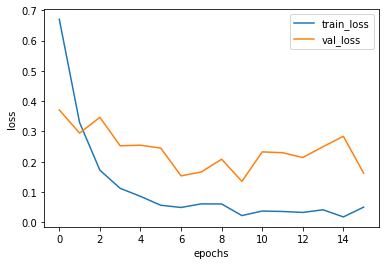

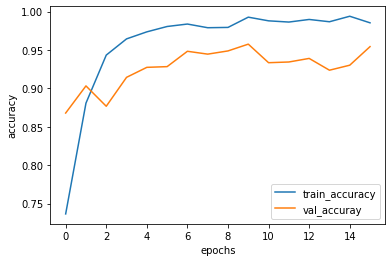

In [ ]:
train_loss = history.history["loss"]
train_accuracy = history.history["accuracy"]
val_loss = history.history["val_loss"]
val_accuray = history.history["val_accuracy"]

plt.plot(train_loss,label="train_loss")
plt.plot(val_loss,label="val_loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.savefig("loss3.png")
plt.show()


plt.plot(train_accuracy,label="train_accuracy")
plt.plot(val_accuray,label="val_accuray")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.savefig("accuracy3.png")
plt.show()

# 绘制验证集混淆矩阵

In [38]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict_generator(val_data)
y_pred_classes = np.argmax(y_pred,axis=1)
y_true = list(load_data("val")[1])
matrix = confusion_matrix(load_data("val")[1],y_pred_classes)
print(matrix)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


验证集：2151
验证集：2151
[[532   4   3   1   1]
 [ 12 420   7   0   5]
 [  1  12 415   0   7]
 [ 18   4   0 326   3]
 [  9   5   5   1 360]]


# 预测并保存到csv

In [39]:
def preprocess_x(x):
    x = tf.io.read_file(x)
    x = tf.io.decode_jpeg(x,channels=3)
    x = tf.image.resize(x,(224,224))
    x = tf.cast(x,dtype=tf.float32) / 255.
    x = np.expand_dims(x,axis=0)
    return x

In [44]:
label2name = list(name2label.keys())
print(label2name)
pre_images = []
pre_label = []
for path in glob.glob("/content/classifcation/prediction/*"):
    pre_images.append(path)
    pre_label.append(label2name[np.argmax(model.predict(preprocess_x(path)),axis=1)[0]]) # 这里的predict_classes不能用
df = pd.DataFrame({"images":pre_images,"pre_label":pre_label})
df.to_csv("predict.csv",index=False)
df

['paper', 'plastic', 'glass', 'cardboard', 'metal']


,images,pre_label
0,/content/classifcation/prediction/trash88.jpg,plastic
1,/content/classifcation/prediction/trash71.jpg,plastic
2,/content/classifcation/prediction/trash36.jpg,paper
3,/content/classifcation/prediction/trash112.jpg,metal
4,/content/classifcation/prediction/trash52.jpg,paper
...,...,...
132,/content/classifcation/prediction/trash56.jpg,plastic
133,/content/classifcation/prediction/trash99.jpg,plastic
134,/content/classifcation/prediction/trash104.jpg,paper
135,/content/classifcation/prediction/trash35.jpg,glass


In [45]:
from google.colab import files
files.download('/content/predict.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# label2name = list(name2label.keys())
# print(label2name)
# pre_images = []
# pre_label = []
# for path in glob.glob("/content/classifcation/prediction/*"):
#     pre_images.append(path)
#     pre_label.append(label2name[model.predict_classes(preprocess_x(path))[0]])
# df = pd.DataFrame({"images":pre_images,"pre_label":pre_label})
# df.to_csv("predict.csv",index=False)
# df

# 可视化预测结果

In [ ]:
model.save('classfication.h5')

In [63]:
!pwd
print(len(pre_images))
print(len(pre_label))

/content
137
137


In [ ]:
##这样应该是可以的，但是这里显示不出来
# f=0
# for t in range(9):
#   for i in range(16):
#       plt.subplot(4,4,i+1)
#       plt.imshow(tf.keras.preprocessing.image.load_img(pre_images[f]))
#       plt.xlabel("predict:" + str(pre_label[f]))
#       f=f+1
# plt.tight_layout()  

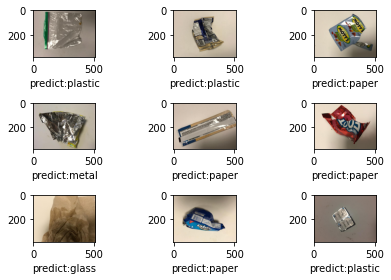

In [69]:
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(tf.keras.preprocessing.image.load_img(pre_images[i]))
    plt.xlabel("predict:" + str(pre_label[i]))
plt.tight_layout()  